# Train the final model

Train the final model based on the results of hyperoptimalization.

1.   Build and train the selected classifier architecture on the bottleNeck features
2.   Assemble the full model by loading InceptionV3 with the weight optained in PreTraining, and put the classifer model at the end of it
3.   Train the whole model to tune every parameter together
4.   Evaluate the results



## 0. Prepare data
Mount my drive to load the bottleNeck features, and unzip the spectrograms to the workspace.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/DeepStep_colab/deepStep_data_spect.zip"

import numpy as np
bottleNeck_loaded = np.load('/content/drive/My Drive/DeepStep_colab/deepStep_bottleNeck_data.npz')

train_bottleNeck = bottleNeck_loaded['train_bottleNeck']
train_labels = bottleNeck_loaded['train_labels']
validate_bottleNeck = bottleNeck_loaded['validate_bottleNeck']
validate_labels = bottleNeck_loaded['validate_labels']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define the folder paths to use during training. 

In [0]:
import os

base_dir = 'data_spect'

train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

Display some of the spectrograms to check if everything is fine.

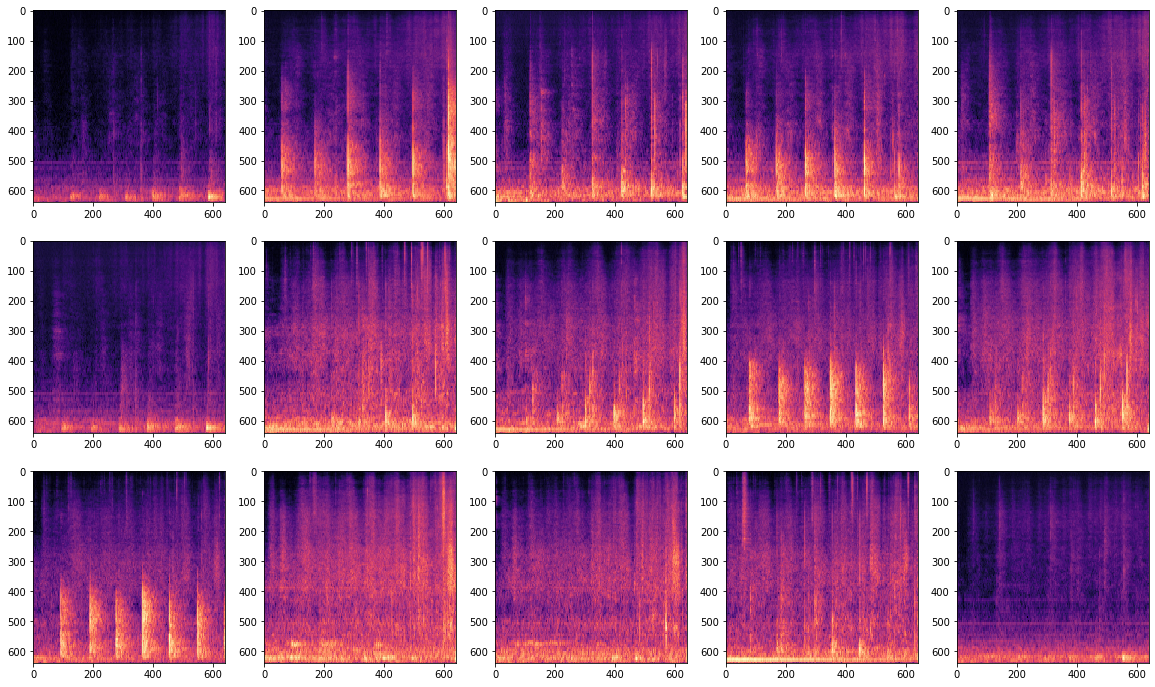

In [3]:
import matplotlib.pyplot as plt
from matplotlib import image

nrows = 3
ncols = 5

fig = plt.figure()
fig.set_size_inches(ncols * 4, nrows * 4)

# Organize the file names to a list
fnames = [os.path.join(path, fname) for path, dirs, files in os.walk(base_dir) for fname in files]

# Plot some of the spectrograms
for i, img_path in enumerate(fnames[:int(ncols*nrows)]):
    sp = plt.subplot(nrows, ncols, i+1)
    img = image.imread(img_path)
    plt.imshow(img)

plt.show()
plt.close()

## 1. Train classifier model

I need to define the Swish activation function to use it in the classifier beforehand. https://stackoverflow.com/questions/53050448/custom-activation-with-parameter

In [4]:
# https://stackoverflow.com/questions/53050448/custom-activation-with-parameter
from keras.layers import Layer
from keras import backend as K

class Swish(Layer):
    def __init__(self, beta, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.beta = K.cast_to_floatx(beta)

    def call(self, inputs):
        return K.sigmoid(self.beta * inputs) * inputs

    def get_config(self):
        config = {'beta': float(self.beta)}
        base_config = super(Swish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


Build the model according to the results of HyperOpt. 

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, InputLayer
from keras.optimizers import SGD

def build_class_model():
    class_model = Sequential(name = 'classification')
    class_model.add(InputLayer(input_shape = (6, 6, 2048)))

    class_model.add(Flatten())

    class_model.add(Dense(units = 64))
    class_model.add(Swish(beta = 0.3))
    class_model.add(Dropout(0.2))

    class_model.add(Dense(units = 6, activation = 'softmax'))

    class_model.compile(optimizer = SGD(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return class_model

Initialize the model and define callbacks.

In [17]:
class_model = build_class_model()
class_model.summary()

Model: "classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4718656   
_________________________________________________________________
swish_5 (Swish)              (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
Total params: 4,719,046
Trainable params: 4,719,046
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Monitor validation accuracy as our benchmark metric in this training:
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True, verbose = 1)
# Save a log of training to my drive
logger = CSVLogger('/content/drive/My Drive/DeepStep_colab/FinalTrain/DeepStep_class_model_training.log.txt')

Train the dense classification layer:

In [19]:
class_model.fit(train_bottleNeck, train_labels,
                epochs = 500,
                batch_size = 16,
                verbose = 1,
                shuffle = True,
                validation_data = (validate_bottleNeck, validate_labels),
                callbacks = [early_stopping, logger])

Train on 512 samples, validate on 64 samples
Epoch 1/500
512/512 [==============================] - 1s 1ms/step - loss: 0.8073 - acc: 0.9180 - val_loss: 0.4343 - val_acc: 0.9688
Epoch 2/500
512/512 [==============================] - 0s 620us/step - loss: 0.2850 - acc: 0.9980 - val_loss: 0.2473 - val_acc: 0.9844
Epoch 3/500
512/512 [==============================] - 0s 612us/step - loss: 0.1647 - acc: 0.9980 - val_loss: 0.1781 - val_acc: 1.0000
Epoch 4/500
512/512 [==============================] - 0s 629us/step - loss: 0.1156 - acc: 1.0000 - val_loss: 0.1431 - val_acc: 1.0000
Epoch 5/500
512/512 [==============================] - 0s 630us/step - loss: 0.0883 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 1.0000
Epoch 6/500
512/512 [==============================] - 0s 604us/step - loss: 0.0781 - acc: 0.9980 - val_loss: 0.1060 - val_acc: 1.0000
Epoch 7/500
512/512 [==============================] - 0s 604us/step - loss: 0.0650 - acc: 1.0000 - val_loss: 0.0951 - val_acc: 1.0000
Epoch 8/500


## 2. Build and train the final model

Define the data generators. Use the built in InceptionV3 image preprocessing method as a basis.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

# Use the built in InceptionV3 image preprocessing method
imDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [21]:
train_generator = imDataGen.flow_from_directory(directory = train_dir,
                                                    target_size = (259, 259),
                                                    shuffle = True, # Shuffle the training data
                                                    batch_size = 16, # Batch size of 16 according to HyperOpt
                                                    class_mode = 'categorical')

validate_generator = imDataGen.flow_from_directory(directory = validate_dir,
                                                       target_size = (259, 259),
                                                       shuffle = True, # No need to shuffle the validation images
                                                       batch_size = 64, # Batch size = 64 means 1 batch will have all the validation images once.
                                                       class_mode = 'categorical')

test_generator = imDataGen.flow_from_directory(directory = test_dir,
                                                       target_size = (259, 259),
                                                       shuffle = False, # No need to shuffle the test images
                                                       batch_size = 63, # Batch size = 63 means 1 batch will have all the test images once.
                                                       class_mode = 'categorical')

Found 512 images belonging to 6 classes.
Found 64 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


Build the full model. Use a slower learning rate to allow for really fine tuning.

In [23]:
from keras.applications import InceptionV3

deepStep_model = Sequential(name = 'DeepStep')

# Add InceptionV3 as the bottom part of the network. Original uses input shape of 299x299, but 259x259 suits the spectrograms better
model_InV3 = InceptionV3(include_top = False, weights = '/content/drive/My Drive/DeepStep_colab/InceptionV3_spectrogram_pretrained_weights.hdf5', input_shape = (259, 259, 3))

deepStep_model.add(model_InV3)
deepStep_model.add(class_model)
  
deepStep_model.compile(optimizer = SGD(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
deepStep_model.summary()

Model: "DeepStep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
classification (Sequential)  (None, 6)                 4719046   
Total params: 26,521,830
Trainable params: 26,487,398
Non-trainable params: 34,432
_________________________________________________________________


Callbacks. Include a model checkpointer, to automatically save the best final model.

In [0]:
# Monitor validation accuracy as our benchmark metric in this training:
early_stopping = EarlyStopping(monitor='val_loss', patience = 30, restore_best_weights = True, verbose = 1)
# Save the best model of rough training to my drive.
checkpointer =  ModelCheckpoint(filepath = '/content/drive/My Drive/DeepStep_colab/FinalTrain/DeepStep_model.hdf5', monitor='val_loss', save_best_only = True)
# Save a log of training to my drive
logger = CSVLogger('/content/drive/My Drive/DeepStep_colab/FinalTrain/DeepStep_class_model_training.log.txt')

Train the model.

In [25]:
history = deepStep_model.fit_generator(train_generator,
                                       epochs = 1000,
                                        verbose = 1,
                                        shuffle = True,
                                        validation_data = validate_generator,
                                        callbacks = [checkpointer, early_stopping, logger])

Epoch 1/1000
32/32 [==============================] - 47s 1s/step - loss: 0.1231 - acc: 0.9824 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 2/1000
32/32 [==============================] - 17s 532ms/step - loss: 0.1506 - acc: 0.9805 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 3/1000
32/32 [==============================] - 17s 532ms/step - loss: 0.0989 - acc: 0.9863 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 4/1000
32/32 [==============================] - 17s 536ms/step - loss: 0.1993 - acc: 0.9863 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 5/1000
32/32 [==============================] - 17s 530ms/step - loss: 0.1054 - acc: 0.9902 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 6/1000
32/32 [==============================] - 17s 530ms/step - loss: 0.1981 - acc: 0.9805 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 7/1000
32/32 [==============================] - 17s 534ms/step - loss: 0.1584 - acc: 0.9805 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 8/1000
32/32 [==============================] - 17s 

## 3. Evaluate the final model.

Plot the training history.

*NOTE*: The batch normalization layers have some weird behaviour when continuing to train a model. This is the reason we see a drop in the performance right at the beginning of fine training compared to the best epoch of the rough training. 

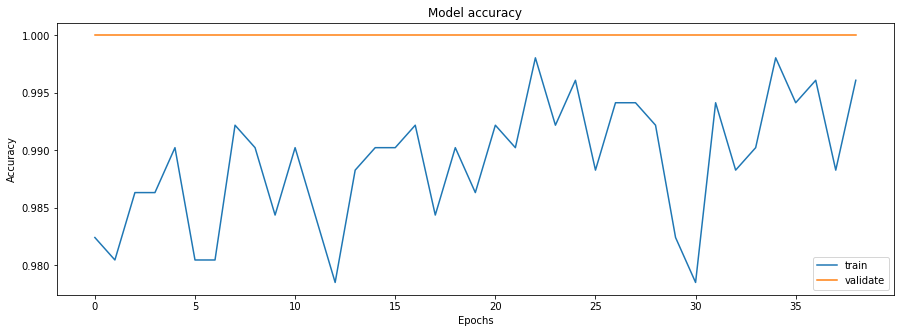

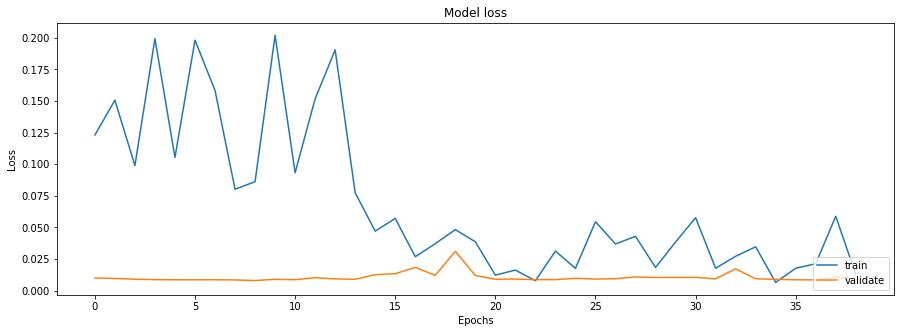

In [26]:
import numpy as np

# Plot model accuracy
plt.figure(figsize = (15,5))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()
plt.close()

# Plot model loss
plt.figure(figsize = (15,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()
plt.close()

Evaluate the test dataset:

In [28]:
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

# Create predictions for the test images
test_confidences = deepStep_model.predict_generator(test_generator, verbose = 0)
test_preds = np.argmax(test_confidences, 1)
# Ground truth labels for the test images (this works because shuffle = False for the test_generator)
test_true = test_generator.labels

print("Test accuracy: %g" %(accuracy_score(test_true, test_preds)))
print("Test loss:", log_loss(test_true, test_confidences)) # Average loss, not sum
print("Test precision:", precision_score(test_true, test_preds, average = "macro"))
print("Test recall:", recall_score(test_true, test_preds, average="macro"))
print("Test f1_score:", f1_score(test_true, test_preds, average="macro"))

Test accuracy: 0.984127
Test loss: 0.046195651923576345
Test precision: 0.9761904761904763
Test recall: 0.9833333333333334
Test f1_score: 0.9784075573549257


Plot a confusion matrix:

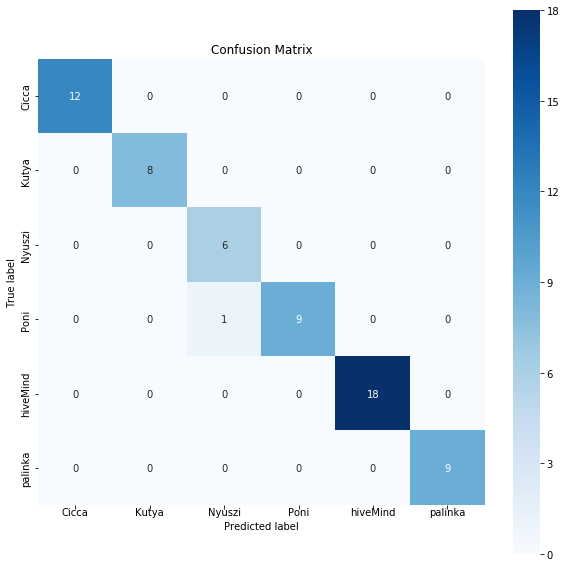

In [29]:
import seaborn as sns

conf = confusion_matrix(test_true, test_preds)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

res = sns.heatmap(conf, annot=True, vmin=0.0, fmt='d', cmap = plt.get_cmap('Blues'))

plt.yticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.ylim([0, 6])
plt.ylabel('True label')
plt.xticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.xlim([0, 6])
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

res.invert_yaxis()

plt.show()
plt.close()

The fact that the network managed to achieve 98% accuracy on both the test dataset could indicate that a) the network might be too big/complex for the task at hand, and b) the dataset migh be too homogenous.

As the end goal is to be able to is to classify many more persons, not just 6, I'm not going to attempt to reduce the complexity of InceptionV3.

Let's find the one image that the model misclassified.

data_spect/test/Poni/Poni_sneaker_19.jpg
Predicted class confidences are: [[2.2784801e-04 1.3992848e-03 8.7453645e-01 1.2325997e-01 3.0658167e-04
  2.6983253e-04]]


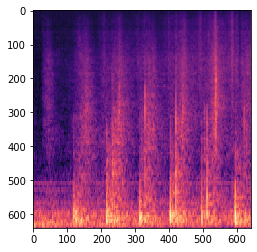

In [31]:
from keras.preprocessing import image

truth = (test_preds != test_true)
misClass_spectrs = np.array(test_generator.filepaths)[np.array(truth)]

for file_path in misClass_spectrs:
    print(file_path)
    in_image = image.load_img(file_path, target_size= (259, 259))
    inp = image.img_to_array(in_image)
    inp = preprocess_input(inp)
    inp = np.expand_dims(inp, axis=0)

    pred = deepStep_model.predict(inp)
    print('Predicted class confidences are: {}'.format(pred))

    plt.figure()
    plt.imshow(image.load_img(file_path))
    plt.show()

There does not seem to be any immediately obvious reason as to why was this sample missclassified.